## Exploring dataset of beer ratings and reviews with PCA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision = 3)

heart_dataset = './assets/mads_SAHeart.csv'
beer_dataset  = './assets/beer2.csv'

Each row of the dataset corresponds to one beer review. 

Each beer is reviewed on a scale from 1 to 5 using these variables:

`review_appearance` :: How appealing is the color, clarity of the beer?

`review_aroma` :: How appealing is the aroma?

`review_palate` :: How appealing is the "palate": the combination of carbonation, mouthfeel, alcohol profile and texture? 

`review_taste` :: How appealing is the taste - e.g. is there a good balance of sweet and bitter?

`review_overall` :: How appealing is the overall experience of drinking this beer?

Each beer record also has several other columns, the most important of which are:

`beer_index` :: unique row number for each beer

`beer_name` :: the name of the specific beer product (note there may be multiple reviews/row for a specific beer name)

`abv` :: alcohol by volume

In [2]:
df = pd.read_csv(beer_dataset)
df = df.dropna()
df.head()

,beer_index,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,10/5/2009 21:31
1,1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,10/5/2009 21:32
2,2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,10/5/2009 21:32
3,3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",10/5/2009 21:32
4,4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3.0,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,10/5/2009 21:33


In [3]:
from sklearn.preprocessing import StandardScaler

feature_names_beer = ['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall','beer_name']

beer_df = df[feature_names_beer]

# Group by beer, and average the review metrics
beer_df = beer_df.groupby(['beer_name']).mean()

# Apply standard normalization
scaler = StandardScaler()
beer_df =scaler.fit(beer_df).transform(beer_df)

#### Apply PCA to obtain 3 principal components

In [4]:
from sklearn.decomposition import PCA

pca = PCA().fit(beer_df)
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

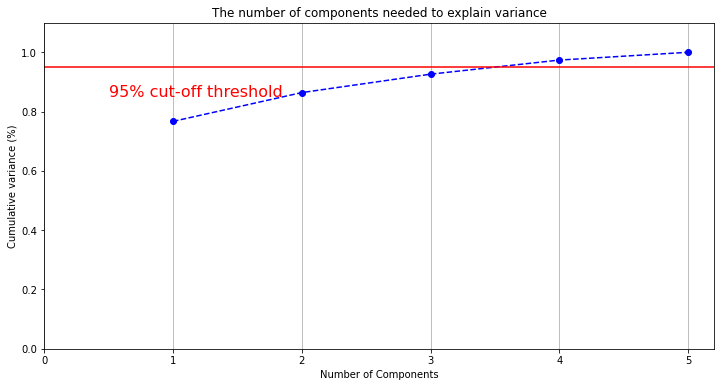

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 6, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 6, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

#### 4 components is the minimum number of components that captures at least 95% of the variance

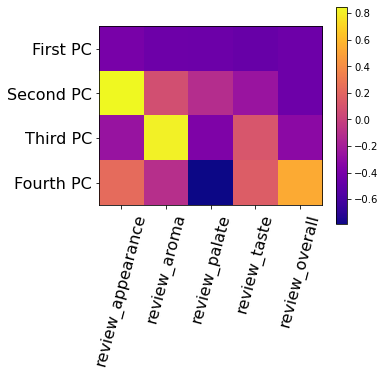

In [6]:
pca = PCA(n_components = 4, random_state = 0).fit(beer_df)

def plot_pca_heatmap(pca, feature_names):
    pc_names = ['First PC', 'Second PC', 'Third PC', 'Fourth PC']
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    plt.xticks(np.arange(0, 5, 1), feature_names, rotation = 75, fontsize=16)
    plt.yticks(np.arange(0.0, 4, 1), pc_names, fontsize = 16)
    plt.colorbar()
    
feature_names = ['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']

plot_pca_heatmap(pca, feature_names)

## Generate biplot of 1st and 2nd component

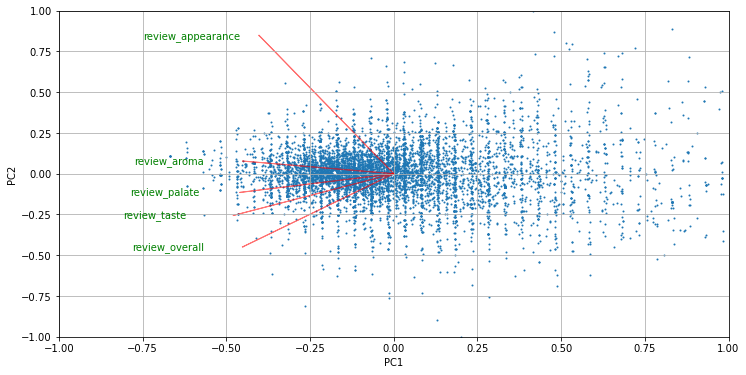

In [7]:
## Routine to generate a high-quality biplot
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.scatter(xs*scalex, ys*scaley, s=1)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure()

# Uncomment this code to generate the biplot using your previous answers

X_beer_pca = pca.transform(beer_df)
biplot(X_beer_pca, np.transpose(pca.components_[0:2, :]), 5, 1, 2, labels=feature_names)


PC1 is correlated most with the variable "review_aroma"

PC2 is correlated most with "review_appearance"